# 5. Predict_test_a-feature_extract

**Tensorboard**
- Input at command: tensorboard --logdir=./log
- Input at browser: http://127.0.0.1:6006

In [1]:
import time
import os
import pandas as pd

project_name = 'SceneClassification'
step_name = 'Predict_test_a-feature_extract'
time_str = time.strftime("%Y%m%d_%H%M%S", time.localtime())
run_name = project_name + '_' + step_name + '_' + time_str
print('run_name: ' + run_name)

cwd = os.getcwd()
model_path = os.path.join(cwd, 'model')
print('model_path: ' + model_path)

run_name: SceneClassification_Predict_test_a-feature_extract_20171028_122246
model_path: E:\SceneClassification\model


### Import pkg

In [2]:
import numpy as np
import pandas as pd
# import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [3]:
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler, TensorBoard

Using TensorFlow backend.


In [4]:
# import zipfile
import os
import zipfile
import math
import time
from IPython.display import display
import pdb
import json
from PIL import Image
import glob
import pickle

### Load model

In [5]:
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K
# from keras.applications.resnet50 import ResNet50
# from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.applications.inception_v3 import InceptionV3

In [7]:
%%time
model = load_model('./model/SceneClassification_Train_20171028_111910_7596.h5')

Wall time: 1min 55s


## Predict validation
- Load image
- Resize image
- Predict
- Get top 1 or 3 or 5
- Calculate score

### Extract zip file

In [10]:
input_path = './input'
datasetName = 'test_a'
date = '20170922'

zip_path = input_path + '/ai_challenger_scene_{0}_{1}.zip'.format(datasetName, date)
extract_path = input_path + '/ai_challenger_scene_{0}_{1}'.format(datasetName, date)
image_path = extract_path + '/scene_{0}_images_{1}'.format(datasetName, date)
scene_classes_path = extract_path + '/scene_classes.csv'
scene_annotations_path = extract_path + '/scene_{0}_annotations_{1}.json'.format(datasetName, date)

print(input_path)
print(zip_path)
print(extract_path)
print(image_path)
print(scene_classes_path)
print(scene_annotations_path)

./input
./input/ai_challenger_scene_test_a_20170922.zip
./input/ai_challenger_scene_test_a_20170922
./input/ai_challenger_scene_test_a_20170922/scene_test_a_images_20170922
./input/ai_challenger_scene_test_a_20170922/scene_classes.csv
./input/ai_challenger_scene_test_a_20170922/scene_test_a_annotations_20170922.json


In [11]:
if not os.path.isdir(extract_path):
    with zipfile.ZipFile(zip_path) as file:
        for name in file.namelist():
            file.extract(name, input_path)

In [12]:
test_images = os.listdir(os.path.join(cwd, 'input', 'data_test_a', 'test'))
print(test_images[0:10])

['00002ff812f48a3df27c321d517a6300ed8da0c3.jpg', '00049a860dca2af378faeb0ee6f435c6063818ef.jpg', '0011a9c9216c3763ffc33641a8ffc975127dc404.jpg', '0045a44cacc7bc9826db9b54d2dcd70b810250f9.jpg', '004b6823145471c6a4ce292e864909fde2d04969.jpg', '0056e4d54eee781117c9d407d03ebf7192126b1f.jpg', '005763f88b25b18ae524b25afcce960403665383.jpg', '005b5444df96e3a155f2a73a8dccc0267e118413.jpg', '005c6ba205a246d0d3c8f73adfd4398b8e483962.jpg', '005de85662d754f98a1476a37b189902800ace91.jpg']


### Load features

In [14]:
%%time
import h5py
import numpy as np
from sklearn.utils import shuffle
np.random.seed(2017)

x_train = []
y_train = {}
x_val = []
y_val = {}
x_test = []

cwd = os.getcwd()
feature_cgg16 = os.path.join(cwd, 'model', 'feature_VGG16_{}.h5'.format(171023))
feature_cgg19 = os.path.join(cwd, 'model', 'feature_VGG19_{}.h5'.format(171023))
feature_resnet50 = os.path.join(cwd, 'model', 'feature_ResNet50_{}.h5'.format(171023))
feature_mobilenet = os.path.join(cwd, 'model', 'feature_MobileNet_{}.h5'.format(171023))
feature_xception = os.path.join(cwd, 'model', 'feature_Xception_{}.h5'.format(171023))
feature_inception = os.path.join(cwd, 'model', 'feature_InceptionV3_{}.h5'.format(171023))
for filename in [feature_cgg16, feature_cgg19, feature_resnet50, feature_mobilenet, feature_xception, feature_inception]:
    with h5py.File(filename, 'r') as h:
        x_train.append(np.array(h['train']))
        y_train = np.array(h['train_label'])
        x_val.append(np.array(h['val']))
        y_val = np.array(h['val_label'])
        x_test.append(np.array(h['test']))

# print(x_train[0].shape)
x_train = np.concatenate(x_train, axis=-1)
# y_train = np.concatenate(y_train, axis=0)
x_val = np.concatenate(x_val, axis=-1)
# y_val = np.concatenate(y_val, axis=0)
x_test = np.concatenate(x_test, axis=-1)
print(x_train.shape)
print(x_train.shape[1:])

print(len(y_train))
print(x_val.shape)
print(len(y_val))
print(x_test.shape)

(53879, 8192)
(8192,)
53879
(7120, 8192)
7120
(7040, 8192)
Wall time: 8.15 s


### Preview "scene_classes.csv"

In [15]:
scene_classes = pd.read_csv(scene_classes_path, header=None)
display(scene_classes.head())

,0,1,2
0,0,航站楼,airport_terminal
1,1,停机坪,landing_field
2,2,机舱,airplane_cabin
3,3,游乐场,amusement_park
4,4,冰场,skating_rink


In [16]:
def get_scene_name(lable_number, scene_classes_path):
    scene_classes = pd.read_csv(scene_classes_path, header=None)
    return scene_classes.loc[lable_number, 2]
print(get_scene_name(0, scene_classes_path))

airport_terminal


### Preview image

./input/ai_challenger_scene_test_a_20170922/scene_test_a_images_20170922
(1, 224, 224, 3)


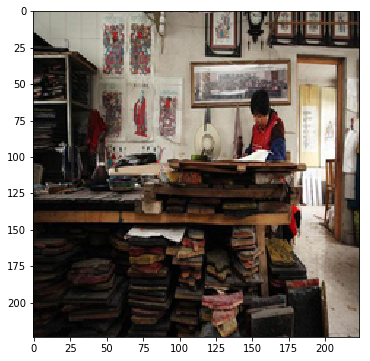

In [26]:
def process_image(image_path, fileName):
    box = (224, 224)
    img_path = image_path + '/' + fileName
    img = Image.open(img_path)
    img1 = img.resize(box, Image.ANTIALIAS) # resizes image in-place
    imgData = np.asarray(img1)
    imgData = imgData.astype("float32")
    imgData = imgData/255.0
    x = np.expand_dims(imgData, axis=0)
    return x

print(image_path)
test_img = process_image(image_path, '00a58de1e260033ed972a7e322a2d8fd315cece6.jpg')
print(test_img.shape)
# print(x)
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(test_img[0])

In [18]:
def decode_predictions(pred, top=3, isPreview=False):
    top_indices = pred.argsort()[-top:][::-1]
    if not isPreview:
        return top_indices
    results  = []
    for i in top_indices:
        result = (i, pred[i])
        results.append(result)
    return results
pred = np.array([3, -1, 2, 7, -2, -1, 0, 6, -9])
print(decode_predictions(pred))
print(decode_predictions(pred, top=5))
print(decode_predictions(pred, top=8, isPreview=True))

[3 7 0]
[3 7 0 2 6]
[(3, 7), (7, 6), (0, 3), (2, 2), (6, 0), (5, -1), (1, -1), (4, -2)]


In [23]:
data_val_path = os.path.join(cwd, 'input', 'data_validation')
data_test_path  = os.path.join(cwd, 'input', 'data_test_a')

gen = ImageDataGenerator()
#     gen = ImageDataGenerator(zoom_range = 0.1,
#                             height_shift_range = 0.1,
#                             width_shift_range = 0.1,
#                             rotation_range = 10)
val_generator  = gen.flow_from_directory(data_val_path,  (224, 224), shuffle=False, batch_size=1)
test_generator  = gen.flow_from_directory(data_test_path,  (224, 224), shuffle=False, batch_size=1)

print(len(val_generator.filenames))
print(val_generator.filenames[0:5])
print(len(test_generator.filenames))
print(test_generator.filenames[0:5])

Found 7120 images belonging to 80 classes.
Found 7040 images belonging to 1 classes.
7120
['class-00\\003ee16dff735e8dc261846d033dc45905a795ea.jpg', 'class-00\\01de277ad1ce84c069f153a790a10613a33aa3a8.jpg', 'class-00\\029376109220f6ce852db458f9523122491bfe2d.jpg', 'class-00\\029fa920f9c33949784b94dfd73fb160b052124d.jpg', 'class-00\\060cbff33fb752f1e66ab4154e36b18e98261454.jpg']
7040
['test\\00002ff812f48a3df27c321d517a6300ed8da0c3.jpg', 'test\\00049a860dca2af378faeb0ee6f435c6063818ef.jpg', 'test\\0011a9c9216c3763ffc33641a8ffc975127dc404.jpg', 'test\\0045a44cacc7bc9826db9b54d2dcd70b810250f9.jpg', 'test\\004b6823145471c6a4ce292e864909fde2d04969.jpg']


In [24]:
preds = model.predict(x_val)
print(preds.shape)
print(preds[0])
print(decode_predictions(preds[0]))
print(decode_predictions(preds[0], top=5, isPreview=True))
lable_id = decode_predictions(preds[0])[0]
print("label_id:{0} lable_text:{1}".format(lable_id, get_scene_name(lable_id, scene_classes_path)))

(7120, 80)
[  9.99997616e-01   4.70378125e-10   3.48593421e-09   1.09795690e-13
   2.09153654e-06   2.15442841e-09   1.42333346e-12   1.46644238e-10
   1.60403579e-10   5.32182805e-12   2.10255879e-09   4.69867418e-12
   1.25083555e-11   1.98221772e-09   1.79462320e-10   5.20335730e-09
   7.46385731e-11   1.56971422e-10   3.28401564e-12   1.36514011e-09
   2.18436241e-11   5.99863041e-13   8.33481992e-13   3.14733916e-13
   6.43296451e-13   3.55773828e-14   3.35208805e-10   1.68677225e-12
   1.81025344e-12   1.73004059e-11   1.98196320e-10   4.73101864e-13
   4.62863525e-08   3.21448618e-10   1.14230611e-10   9.84101863e-12
   3.68352566e-08   2.70350842e-11   4.65624176e-13   3.21206395e-11
   2.45987813e-11   9.44389636e-11   1.65536544e-08   3.18630747e-11
   1.16491844e-10   2.44730458e-10   7.54051127e-11   1.01410904e-12
   4.33721045e-11   3.78164756e-11   1.67417660e-11   4.69216376e-12
   2.58002203e-10   9.97263456e-14   2.68479248e-08   1.79762367e-07
   7.64743657e-10   8.8

In [44]:
from keras.utils.np_utils import to_categorical

y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
print(y_train.shape)
print(y_val.shape)

(53879, 80)
(7120, 80)


In [45]:
final_loss, final_acc = model.evaluate(x_val, y_val, verbose=0)
print("Final loss: {0:.4f}, final accuracy: {1:.4f}".format(final_loss, final_acc))

Final loss: 1.3348, final accuracy: 0.7597


In [59]:
%%time
results = []
count = len(val_generator.filenames)
# count = 10 # For test

print('Image amount:{}'.format(count))
for i, file in enumerate(val_generator.filenames):
    file = file[-44:]
#     print(i)
#     print(file)
    labels = decode_predictions(preds[i])
    result = {}
    result['label_id'] = labels.tolist()
    result['image_id'] = file
    results.append(result)
    count = count -1
    if count <= 0:
        break

# print(results)
submit_file = './output' + '/submit' + time.strftime("%Y%m%d_%H%M%S", time.localtime()) + '.json'
print(submit_file)
with open(submit_file, 'w') as f:
    json.dump(results, f)
    result_amount = len(results)
    print('Image amount:{0}, result amount:{1}'.format(len(val_generator.filenames), result_amount))

Image amount:7120
./output/submit20171028_132121.json
Image amount:7120, result amount:7120
Wall time: 360 ms


In [60]:
%run ./scene_classification_eval/scene_eval.py --submit ./scene_classification_eval/submit.json --ref ./scene_classification_eval/ref.json

Evaluation time of your result: 0.000000 s
{'error': [], 'score': '1.0', 'warning': []}


In [62]:
# %%time
%run ./scene_classification_eval/scene_eval.py --submit ./output/submit20171028_132121.json  --ref ./output/scene_validation_annotations_20170908.json

Evaluation time of your result: 5.656765 s
{'error': [], 'score': '0.9096910112359551', 'warning': []}
